```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import mpld3

import subprocess
import socket
import time
import os
import gc
import datetime
import logging

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [2]:
#Finally, import our simulator
from GPUSimulators import Common, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, IPythonMagic
from GPUSimulators.helpers import InitialConditions

In [3]:
%setup_logging
%cuda_context_handler cuda_context

Console logger using level INFO
File logger using level DEBUG to output.log
Python version 3.6.7 |Anaconda custom (64-bit)| (default, Oct 28 2018, 19:44:12) [MSC v.1915 64 bit (AMD64)]
Registering cuda_context in user workspace
PyCUDA version 2018.1.1
CUDA version (10, 0, 0)
Driver version 10000
Using 'GeForce 840M' GPU
Created context handle <261834906624>
Using CUDA cache dir c:\Users\anbro\Documents\projects\GPUSimulators\GPUSimulators\cuda_cache
Autotuning enabled. It may take several minutes to run the code the first time: have patience


In [4]:
#Misc plotting setup
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1', 5]) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':', '-.']) +
                       #cycler('markersize', [5, 5, 5, 5, 5, 5]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k', 'k']) )    

#Set large figure sizes
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'
#plt.rcParams['legend.markerscale'] = 1.0
#plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.markeredgewidth'] = 1.5
#plt.rcParams['savefig.dpi'] = 400

In [5]:
def save_figure(fig, stem):
    if (not os.path.isdir("figures")):
        os.mkdir("figures")
    
    fig_filename = os.path.join("figures", "convergence_smooth1d_" + stem + ".pdf")
    
    metadata = {
        'created': time.strftime("%Y_%m_%d-%H_%M_%S"),
        'hostname': socket.gethostname()
    }
        
    legend = fig.gca().legend_
    if (legend != None):
        fig.savefig(fig_filename, dpi=300,format='pdf',
                transparent=True, pad_inches=0.0, frameon=None, 
                metadata=metadata, 
                bbox_extra_artists=(legend, ), bbox_inches='tight')
    else:
        fig.savefig(fig_filename, dpi=300,format='pdf',
                transparent=True, pad_inches=0.0, frameon=None, 
                metadata=metadata)

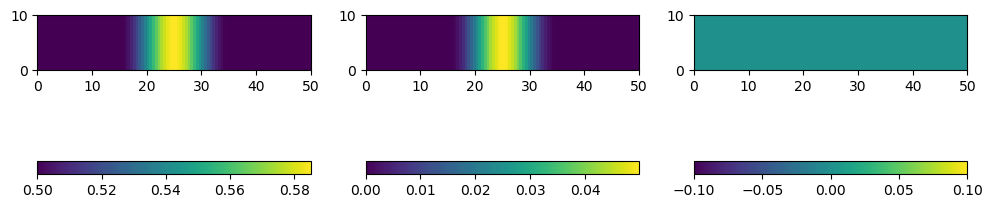

In [6]:
nx = 100
ny = 2
ref_nx = 1000
width = 50
height = width/5
bump_size = 10
h, hu, hv, dx, dy = InitialConditions.bump(nx=nx, ny=ny, width=width, height=height, bump_size=bump_size, ref_nx=ref_nx, v_amp=0, v_ref=0)

plt.figure()
ax=plt.subplot(1,3,1)
im=plt.imshow(h, extent=[0, nx*dx, 0, ny*dy])
plt.colorbar(orientation='horizontal')

ax=plt.subplot(1,3,2)
im=plt.imshow(hu, extent=[0, nx*dx, 0, ny*dy])
plt.colorbar(orientation='horizontal')

ax=plt.subplot(1,3,3)
im=plt.imshow(hv, extent=[0, nx*dx, 0, ny*dy])
plt.colorbar(orientation='horizontal')

plt.show()


In [7]:
def gen_filename(simulator, nx):
    return os.path.abspath(os.path.join("data", "smooth1d", str(simulator.__name__) + "_" + str(nx) + ".npz"))

In [8]:
def run_benchmark(datafilename, simulator, simulator_args, nx, reference_nx, ny, reference_ny,
                  h_ref=0.5, h_amp=0.1, u_ref=0.0, u_amp=0.1, v_ref=0.0, v_amp=0.1,
                  dt=None, force_rerun=False, transpose=False):

    if (datafilename and os.path.isfile(datafilename) and force_rerun == False):
        print("WARNING: Existing simulation exists, skipping simulation")
        return [0, 0, 0]
    else:
        width=100
        test_data_args= {
            'nx': nx,
            'ny': ny,
            'width': width,
            'height': 2*width/nx,
            'bump_size': width/5,
            'ref_nx': reference_nx,
            'ref_ny': reference_ny,
            'h_ref': h_ref, 'h_amp': h_amp,
            'u_ref': u_ref, 'u_amp': u_amp,
            'v_ref': v_ref, 'v_amp': v_amp
        }
        h0, hu0, hv0, dx, dy = InitialConditions.bump(**test_data_args)

        #Initialize simulator
        with Common.Timer(simulator.__name__ + "_" + str(nx)) as timer:
            if (transpose):
                h0 = np.ascontiguousarray(np.transpose(h0))
                hu0, hv0 = np.ascontiguousarray(np.transpose(hv0)), np.ascontiguousarray(np.transpose(hu0))
                dx, dy = dy, dx
                nx, ny = ny, nx
                
            sim_args = {
                'h0': h0, 'hu0': hu0, 'hv0': hv0,
                'nx': nx, 'ny': ny,
                'dx': dx, 'dy': dy
            }
            sim_args.update(simulator_args)

            sim = simulator(**sim_args)
            sim.simulate(1.0, dt=dt)
            sim.check()
            
            nt = sim.simSteps()
            dt = sim.simTime() / nt
            h, hu, hv = sim.download()
            
            if (transpose):
                h = np.ascontiguousarray(np.transpose(h))
                hu, hv = np.ascontiguousarray(np.transpose(hv)), np.ascontiguousarray(np.transpose(hu))
            

            if (datafilename):
                dirname = os.path.dirname(datafilename)
                if (dirname and not os.path.isdir(dirname)):
                    os.makedirs(dirname)
                np.savez_compressed(datafilename, h=h, hu=hu, hv=hv)
        
    gc.collect() # Force run garbage collection to free up memory
    
    return [timer.secs, nt, dt]

In [9]:
reference_nx = 16384
domain_sizes = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
force_rerun=True
transpose=False
g = 9.81
h_ref = 0.5
h_amp = 0.1
u_ref = 0.0
u_amp = 0.1
dt = 0.7*(width/reference_nx)/(u_ref+u_amp + np.sqrt(g*(h_ref+h_amp)))
dt = None
sim_args = {
    'context': cuda_context,
    'cfl_scale': 0.9,
    'g': g
}

#reference_nx = 4096
#domain_sizes = [32, 64, 128, 256, 512, 1024]

sim_elapsed_time = np.zeros((len(simulators), len(domain_sizes)))
sim_dt = np.zeros((len(simulators), len(domain_sizes)))
sim_nt = np.zeros((len(simulators), len(domain_sizes)))


#Warmup to compile kernels
with Common.Timer("warmup") as timer:
    for i in range(len(simulators)):
        run_benchmark(None, 
                      simulators[i], 
                      sim_args,
                      16, 16, 2, 2,
                      force_rerun=force_rerun,
                      transpose=transpose)
print("Completed warmup in {:} s".format(timer.secs))
    
with Common.Timer("simulation") as timer:
    for i in range(len(simulators)):        
        # Run the simulation for all the domain sizes
        for j, nx in enumerate(domain_sizes):
            datafilename = gen_filename(simulators[i], nx)
            [secs, nt, dt] = run_benchmark(datafilename, 
                                simulators[i], 
                                sim_args,
                                nx, reference_nx, 2, 2,
                                h_ref=h_ref, h_amp=h_amp,
                                u_ref=u_ref, u_amp=u_amp, 
                                v_ref=0.0, v_amp=0.0,
                                #dt=0.25*0.7*(width/nx)/(u_ref+u_amp + np.sqrt(g*(h_ref+h_amp))),
                                force_rerun=force_rerun,
                                transpose=transpose)
            sim_elapsed_time[i, j] = secs
            sim_dt[i, j] = dt
            sim_nt[i, j] = nt

        # Run reference with a low CFL-number
        datafilename = gen_filename(simulators[i], reference_nx)
        run_benchmark(datafilename, 
                      simulators[i], 
                      sim_args,
                      reference_nx, reference_nx, 2, 2,
                      h_ref=h_ref, h_amp=h_amp,
                      u_ref=u_ref, u_amp=u_amp,
                      v_ref=0.0, v_amp=0.0,
                      #dt=0.25*0.7*(width/reference_nx)/(u_ref+u_amp + np.sqrt(g*(h_ref+h_amp))),
                      force_rerun=force_rerun,
                      transpose=transpose)
print("Completed simulation in {:} s".format(timer.secs))

Completed warmup in 9.048018217086792 s


HLL2 [16384x2]: 0% [################==============] 100%. Total: 9s, elapsed: 5s, remaining: 4s
KP07 [16384x2]: 0% [###############===============] 100%. Total: 9s, elapsed: 5s, remaining: 4s
KP07_dimsplit [16384x2]: 0% [#################=============] 100%. Total: 8s, elapsed: 5s, remaining: 3s
WAF [16384x2]: 0% [################==============] 100%. Total: 9s, elapsed: 5s, remaining: 4s


Completed simulation in 63.03895831108093 s


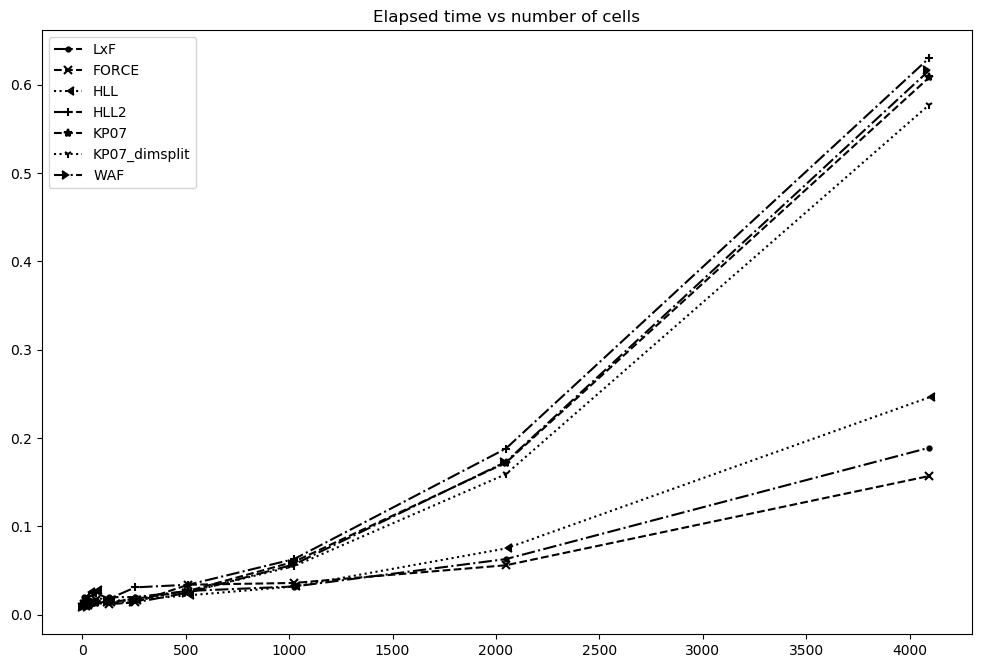

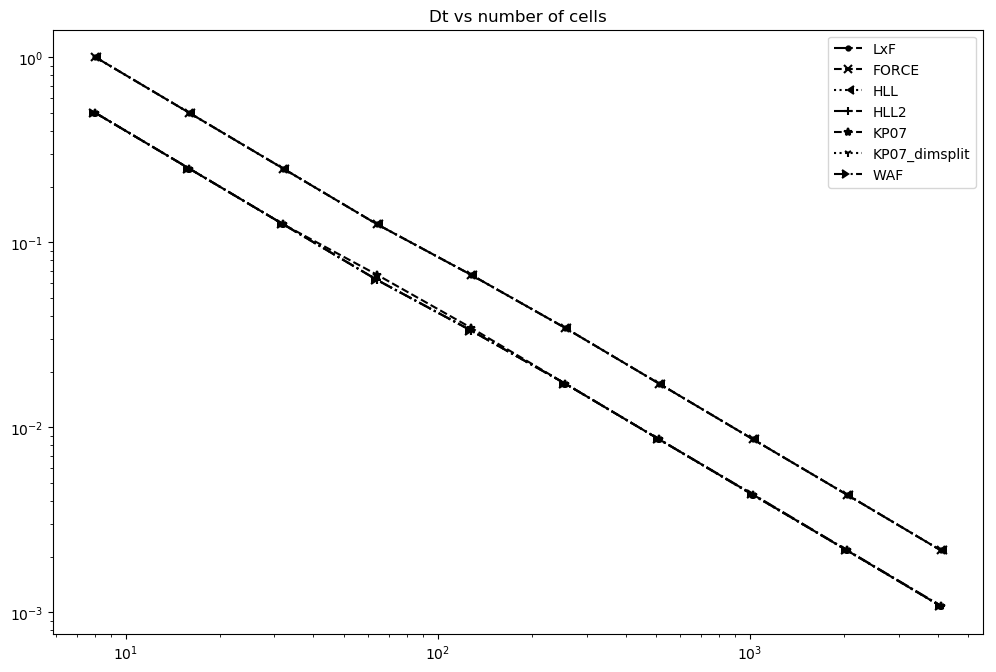

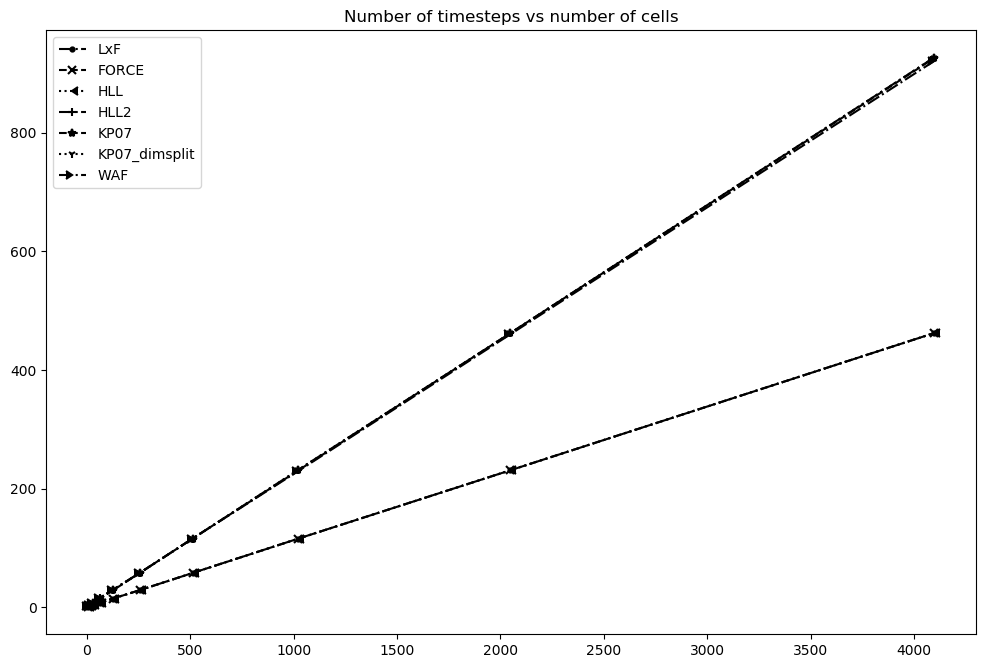

In [10]:
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Elapsed time vs number of cells")
for i, simulator in enumerate(simulators):
    plt.plot(domain_sizes, sim_elapsed_time[i,:], label=simulator.__name__)
plt.legend()
    
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Dt vs number of cells")
for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, sim_dt[i,:], label=simulator.__name__)
plt.legend()
    
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Number of timesteps vs number of cells")
for i, simulator in enumerate(simulators):
    plt.plot(domain_sizes, sim_nt[i,:], label=simulator.__name__)
plt.legend()

c:\Users\anbro\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_pdf.py:594: UserWarning: Unknown infodict keyword: created
  self.writeInfoDict()
c:\Users\anbro\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_pdf.py:594: UserWarning: Unknown infodict keyword: hostname
  self.writeInfoDict()


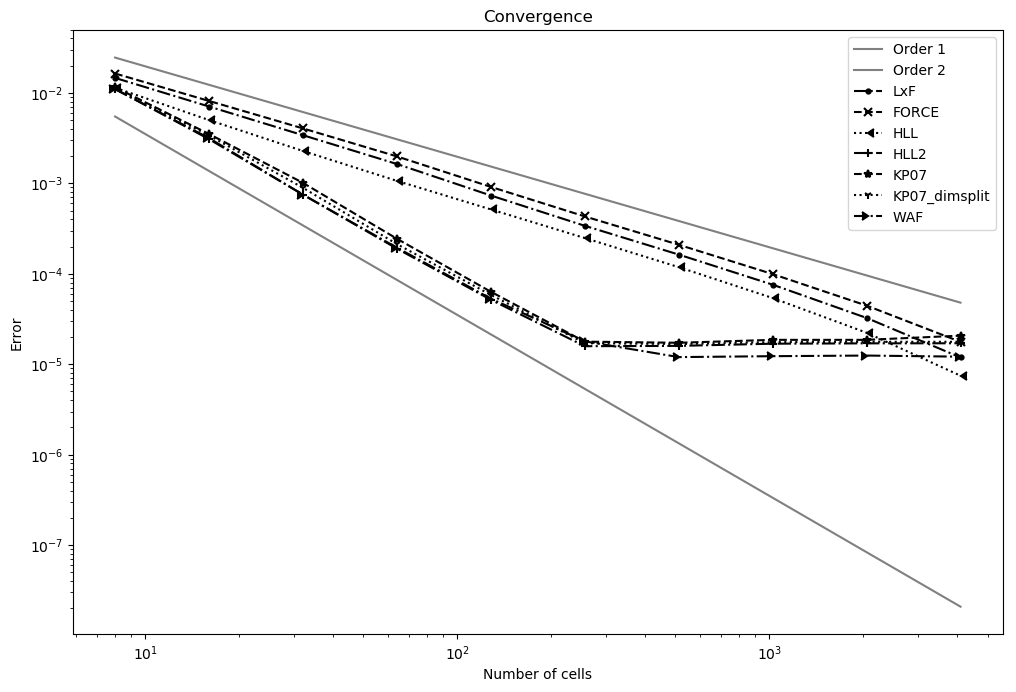

In [11]:
conservation = np.zeros((len(simulators), len(domain_sizes)))
error = np.zeros((len(simulators), len(domain_sizes)))
order = np.zeros((len(simulators), len(domain_sizes)-1))

for i, simulator in enumerate(simulators):
    #Read the reference solution
    datafilename = gen_filename(simulator, reference_nx)
    with np.load(datafilename) as data:
        h_ref = data['h'].astype(np.float64)
    
    #Compute conservation and error for subsequent resolutions
    for j, nx in enumerate(domain_sizes):
        #Read current resolution
        datafilename = gen_filename(simulator, nx)
        with np.load(datafilename) as data:
            h = data['h'].astype(np.float64)
        
        #Downsample reference to current resolution
        h_ref_downsampled = InitialConditions.downsample(h_ref, reference_nx/nx, 1)
        
        #Compute error per cell
        error[i, j] = np.linalg.norm((h_ref_downsampled - h).flatten(), ord=1) / nx
        conservation[i, j] = (np.sum(h_ref) - np.sum(h))
    
    #Compute the numerical order
    a = np.arange(1, len(domain_sizes))
    order[i,:] = np.log2(error[i, :-1] / error[i, 1:])
    
fig = plt.figure()
setBwStyles(fig.gca())

x = np.linspace(domain_sizes[0], domain_sizes[-1], 100);

scaling = np.max(error[:,0]) * domain_sizes[0] * 1.5
plt.loglog(x, scaling/x, '-', color='gray', label='Order 1')

scaling = np.min(error[:,0]) * domain_sizes[0]**2 * 0.5
plt.loglog(x, scaling/(x*x), '-', color='gray', label='Order 2')

for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, error[i,:], label=simulators[i].__name__)
    
plt.xlabel('Number of cells')
plt.ylabel('Error')
plt.title("Convergence")
plt.legend()
save_figure(fig, 'convergence')

In [12]:
import pandas as pd
from IPython.display import display

table = pd.DataFrame(order, columns=domain_sizes[:-1], index=[simulator.__name__ for simulator in simulators])
display(table)

order_summary = pd.DataFrame(np.empty((len(simulators), 3)), columns=['Max', 'Min', 'Mean'], index=[simulator.__name__ for simulator in simulators])
for i, simulator in enumerate(simulators):
    order_summary.loc[simulator.__name__] = [np.max(order[i,:]), 
        np.min(order[i,:]), 
        np.mean(order[i,:])]
display(order_summary)


,8,16,32,64,128,256,512,1024,2048
LxF,1.050319,1.053274,1.057580,1.156900,1.112672,1.056534,1.105822,1.220962,1.451973
FORCE,1.007614,1.008834,1.027290,1.120006,1.083984,1.040525,1.077175,1.157898,1.331487
HLL,1.189025,1.134724,1.097368,1.048309,1.050748,1.069668,1.134412,1.273147,1.579864
HLL2,1.847526,2.036225,1.983265,1.878620,1.705259,-0.011363,-0.080663,-0.012393,-0.002810
KP07,1.717514,1.793747,2.052227,1.946411,1.832907,0.041538,-0.107267,0.000060,-0.153888
KP07_dimsplit,1.744111,1.921536,2.067071,1.865104,1.776602,0.029395,-0.070670,-0.011872,0.000299
WAF,1.793207,2.077181,1.945985,1.869656,1.569657,0.579323,-0.033551,-0.022996,0.041110


,Max,Min,Mean
LxF,1.451973,1.050319,1.140671
FORCE,1.331487,1.007614,1.094979
HLL,1.579864,1.048309,1.175252
HLL2,2.036225,-0.080663,1.038185
KP07,2.052227,-0.153888,1.013694
KP07_dimsplit,2.067071,-0.070670,1.035731
WAF,2.077181,-0.033551,1.091063


c:\Users\anbro\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_pdf.py:594: UserWarning: Unknown infodict keyword: created
  self.writeInfoDict()
c:\Users\anbro\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_pdf.py:594: UserWarning: Unknown infodict keyword: hostname
  self.writeInfoDict()


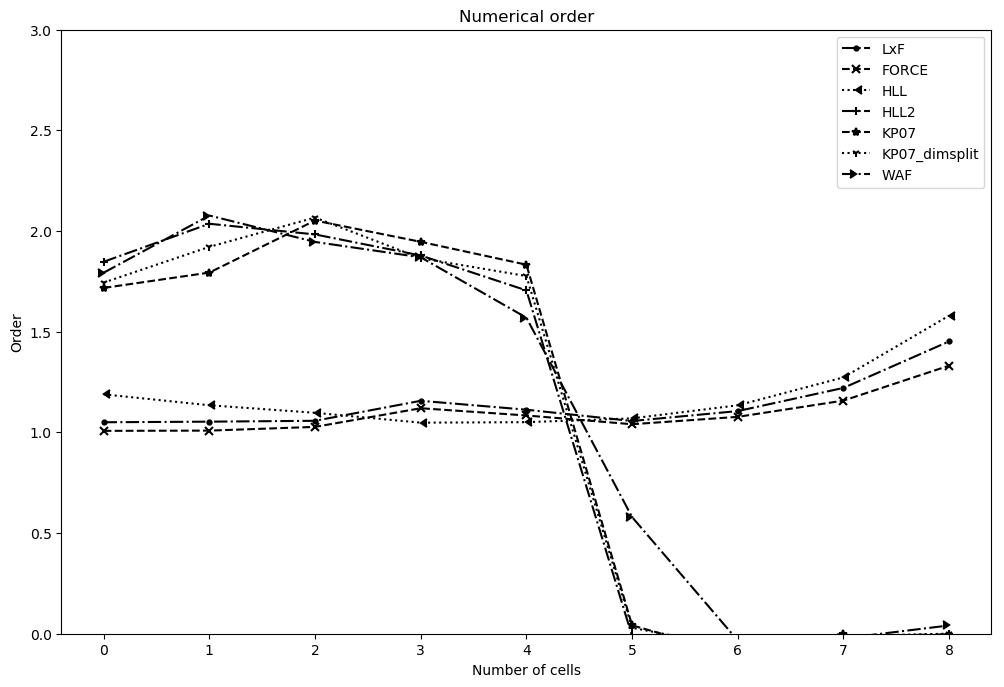

In [13]:
fig = plt.figure()
setBwStyles(fig.gca())

for i, simulator in enumerate(simulators):
    plt.plot(order[i,:], label=simulator.__name__)
    
plt.ylim([0, 3])
plt.xlabel('Number of cells')
plt.ylabel('Order')
plt.legend()
plt.title("Numerical order")
save_figure(fig, 'numerical_order')

In [14]:
def plot_solution(simulator, nx, label, **kwargs):
    datafilename = gen_filename(simulator, nx)
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        
    x = np.linspace(0.5, nx-0.5, nx)*100.0/float(nx)
    y = h[0,:]
    
    plt.plot(x, y, label=label, **kwargs)
    
    h = None
    x = None
    gc.collect() # Force run garbage collection to free up memory
    
def plot_comparison(nx, **kwargs):
    plot_solution(HLL2.HLL2, reference_nx, 'Reference', marker=' ', linestyle='-')

    for i, simulator in enumerate(simulators):
        plot_solution(simulator, nx, simulator.__name__, **kwargs)

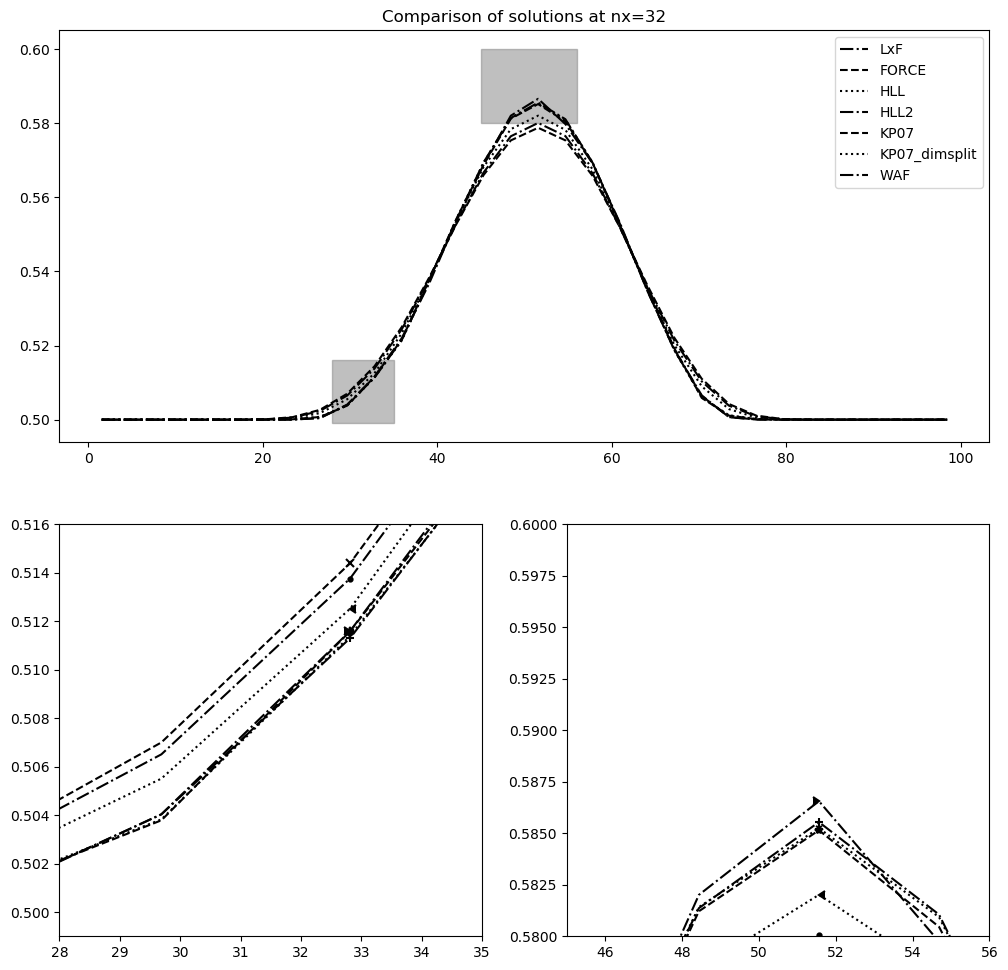

In [15]:
boxes = np.array([\
         [[28, 35], [0.499, 0.516]], \
         [[45, 56], [0.58, 0.60]]
         ])
comparison_nx = 32

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
    
ax1 = fig.add_subplot(gs[0,:])
setBwStyles(ax1)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, marker=' ')
for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
plt.title("Comparison of solutions at nx=" + str(comparison_nx))
plt.legend()

ax2 = fig.add_subplot(gs[1,0])
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, markevery=2)
plt.xlim(boxes[0, 0])
plt.ylim(boxes[0, 1])

ax3 = fig.add_subplot(gs[1,1])
setBwStyles(ax3)
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, markevery=2)
plt.xlim(boxes[1, 0])
plt.ylim(boxes[1, 1])
    
save_figure(fig, 'solution')

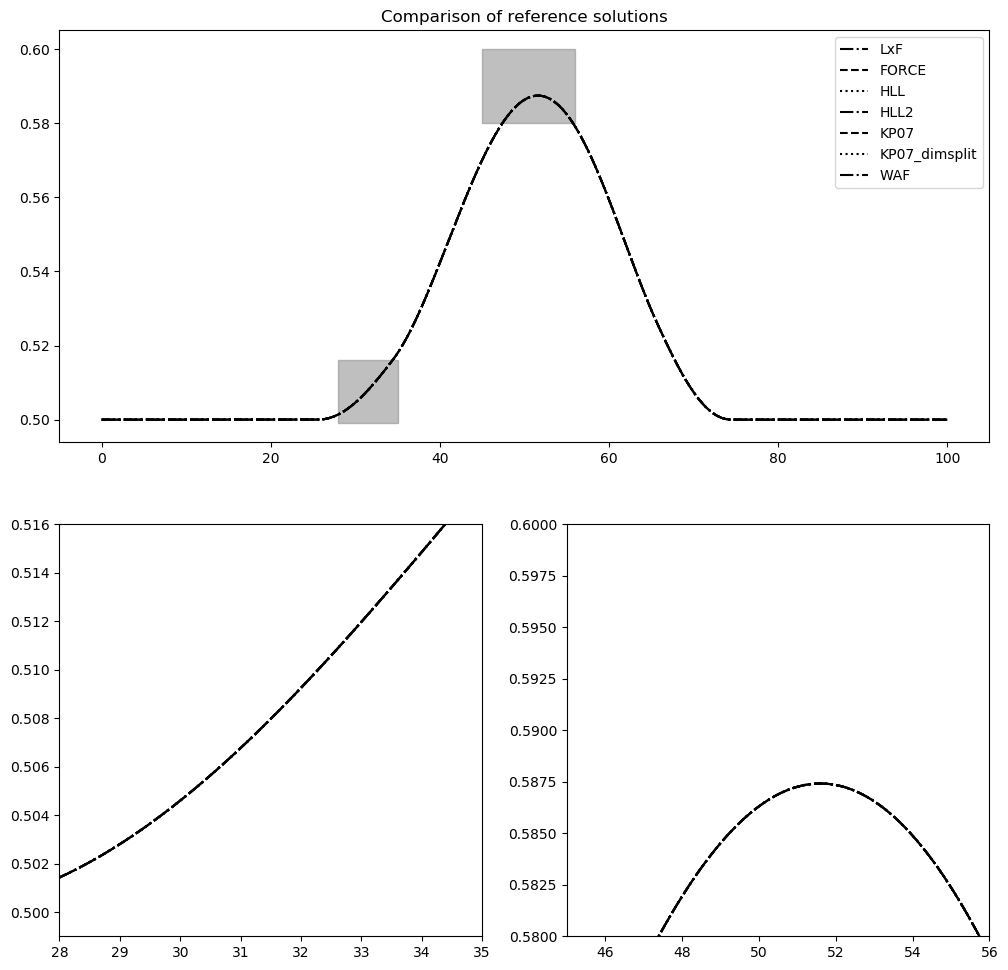

In [16]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
    
ax1 = fig.add_subplot(gs[0,:])
setBwStyles(ax1)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
plt.title("Comparison of reference solutions")
plt.legend()

ax2 = fig.add_subplot(gs[1,0])
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
plt.xlim(boxes[0, 0])
plt.ylim(boxes[0, 1])

ax3 = fig.add_subplot(gs[1,1])
setBwStyles(ax3)
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
plt.xlim(boxes[1, 0])
plt.ylim(boxes[1, 1])
    
save_figure(fig, 'reference_solutions')

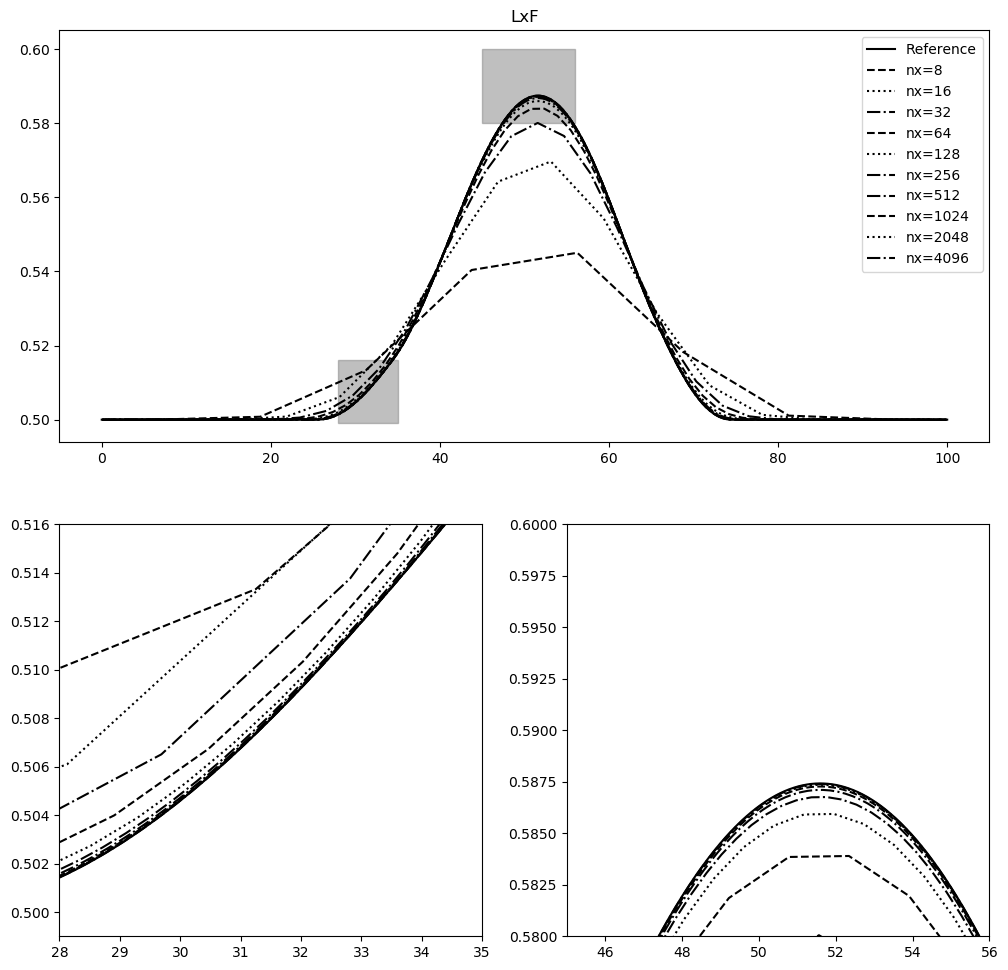

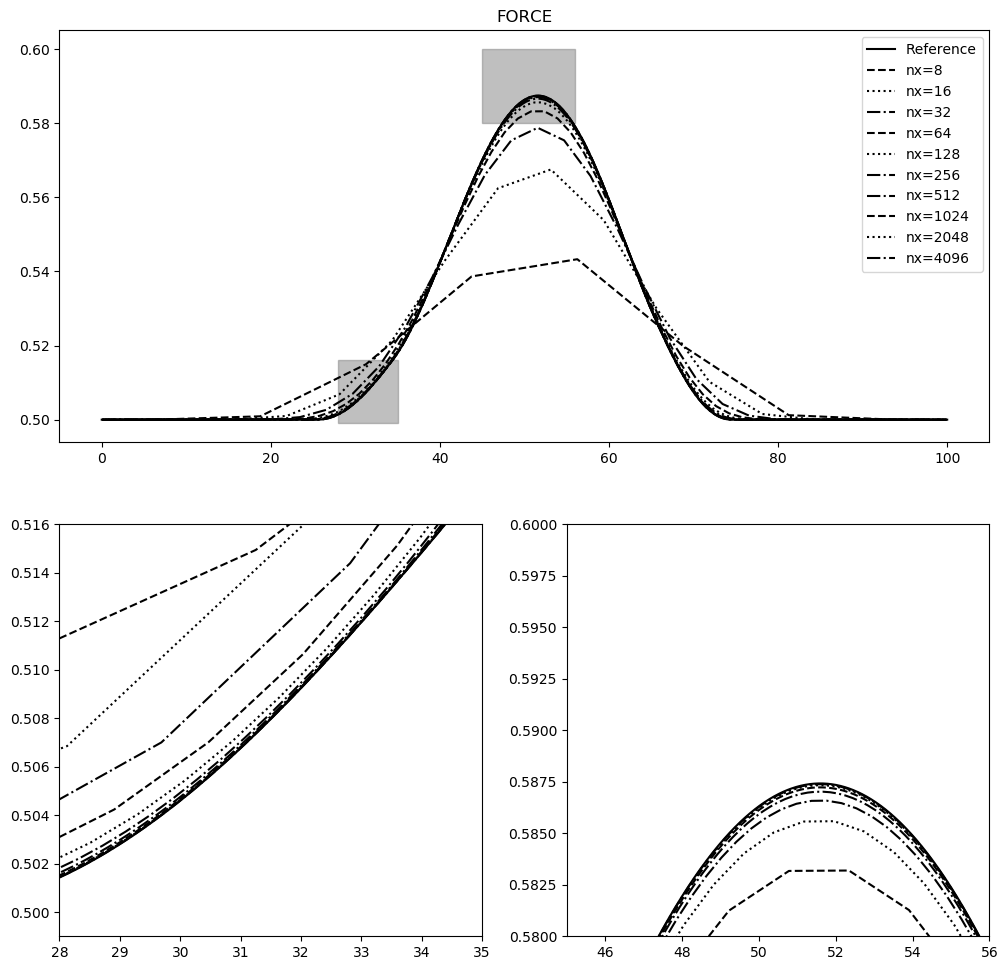

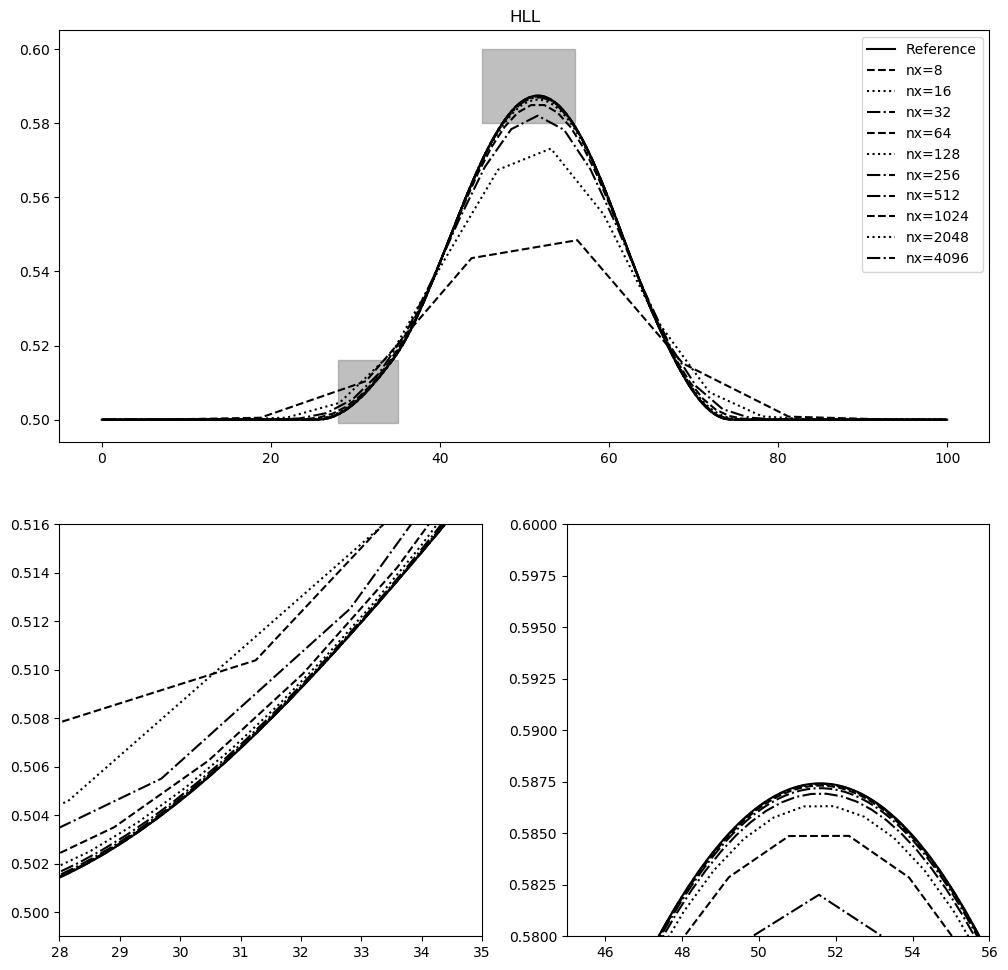

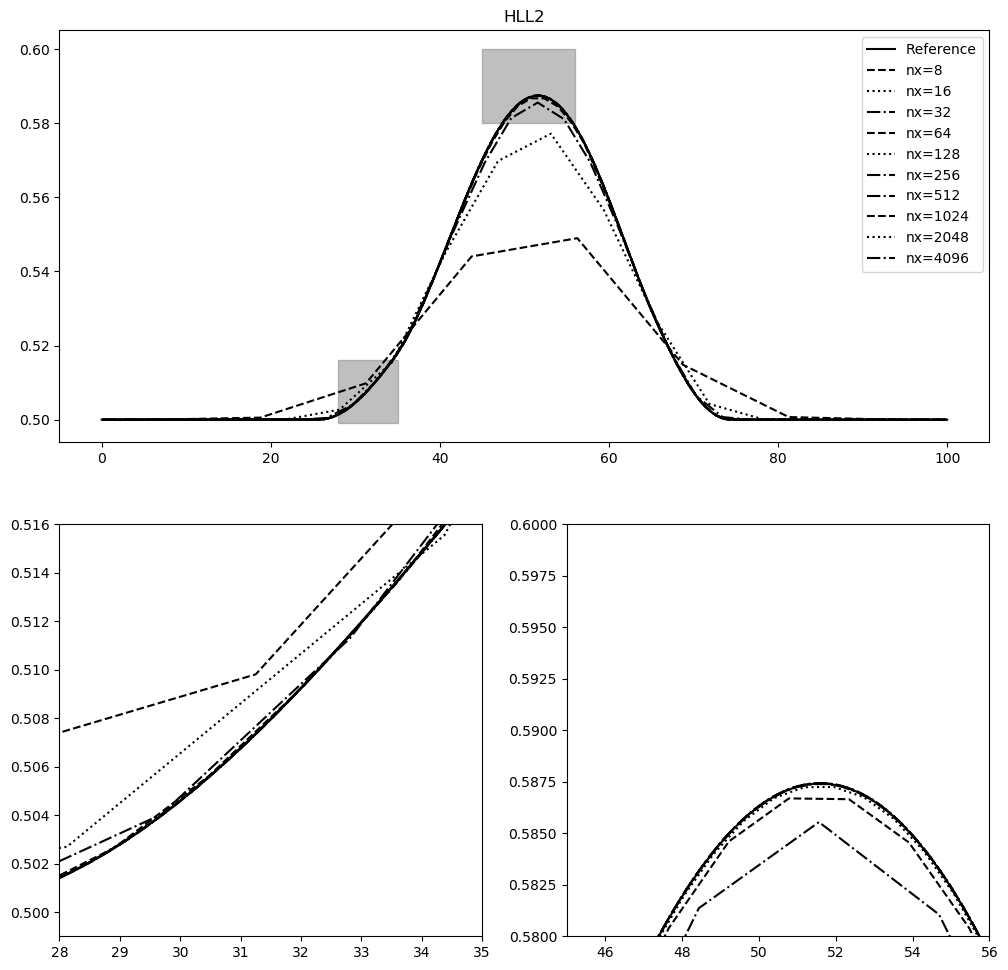

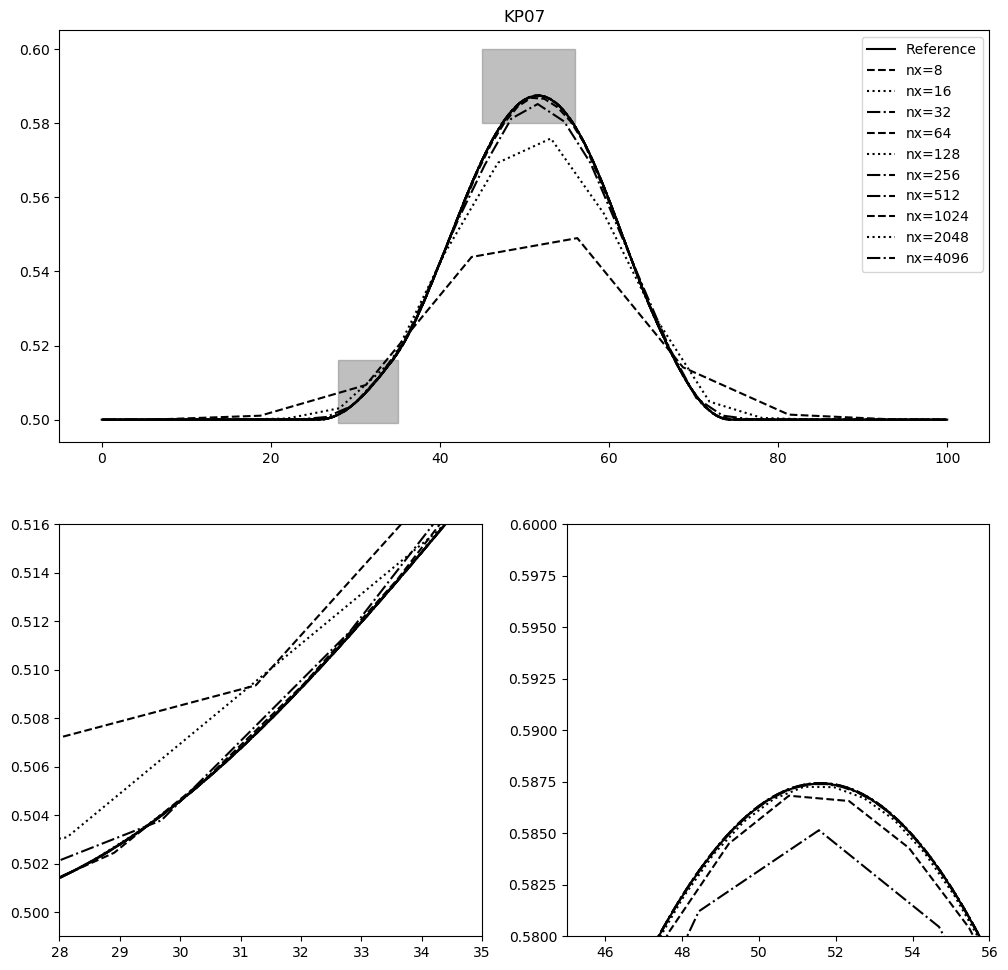

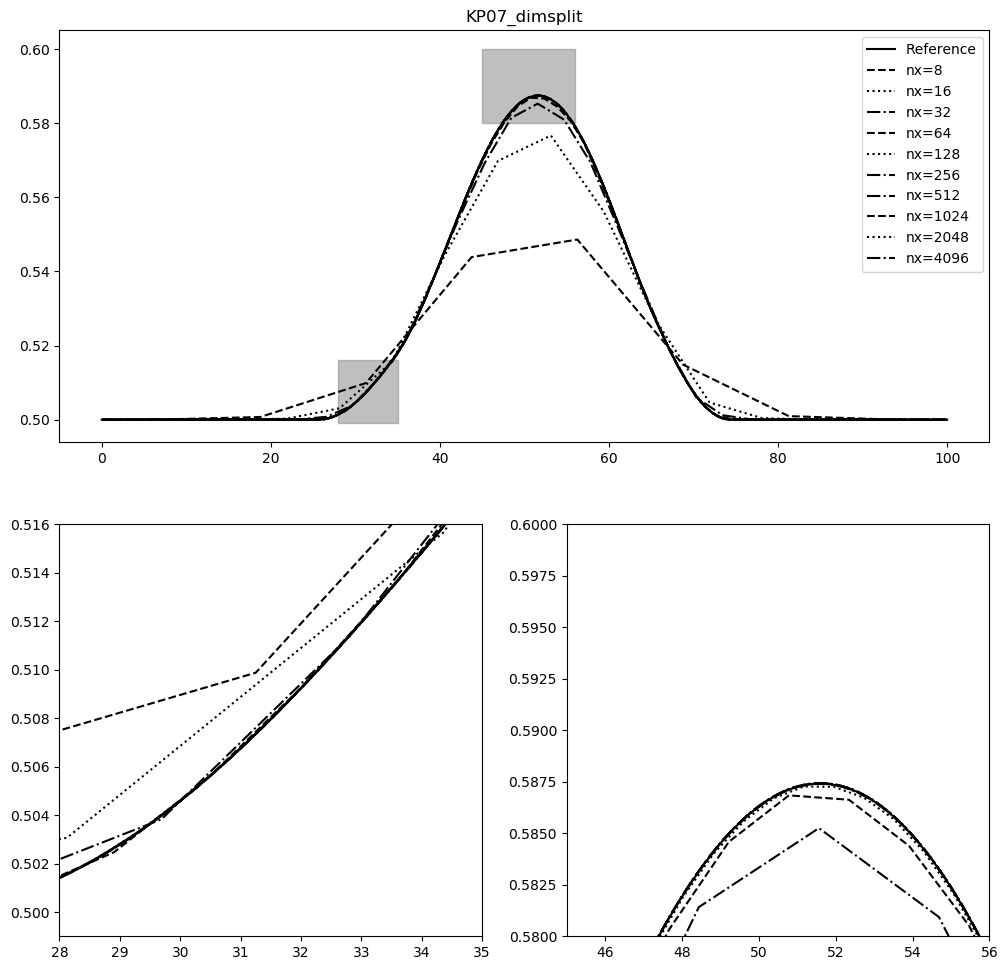

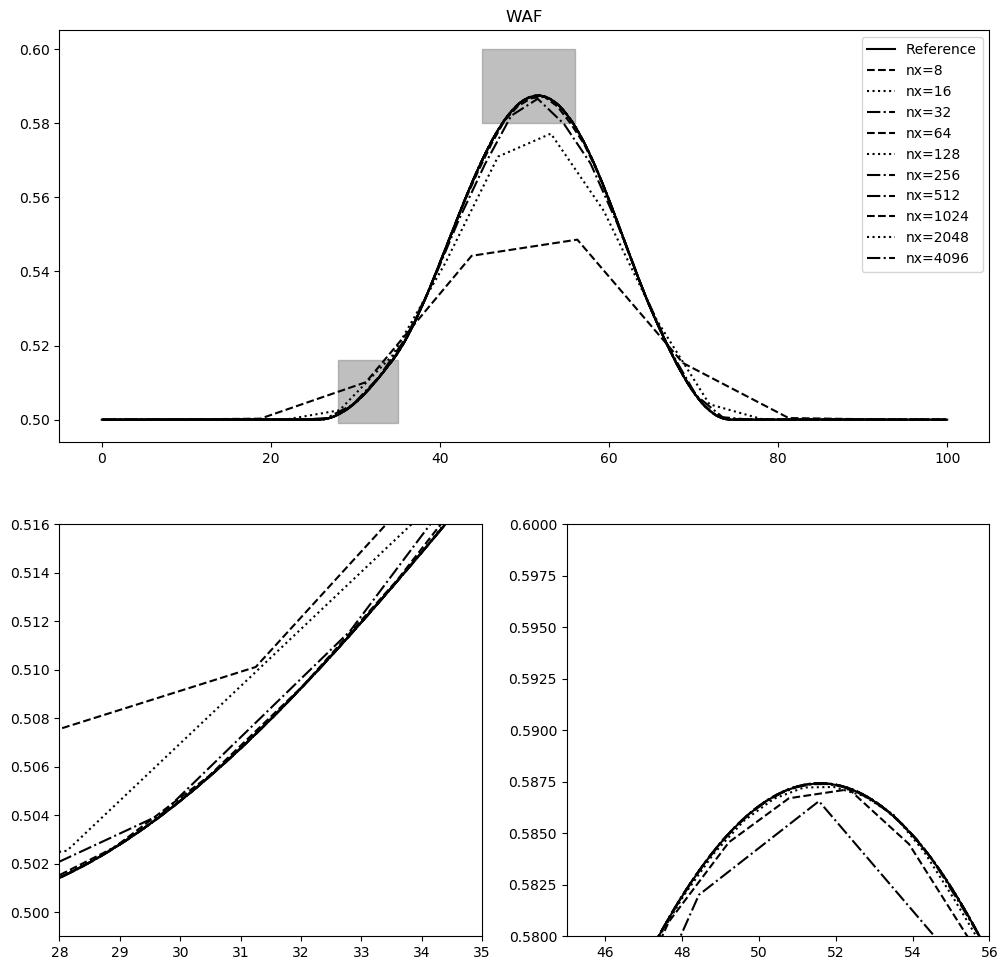

In [17]:
for simulator in simulators:
    fig = plt.figure(figsize=(12, 12))
    
    gs = gridspec.GridSpec(2, 2)
    
    ax1 = fig.add_subplot(gs[0,:])
    setBwStyles(ax1)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')
    for box_x, box_y in boxes:
        x = np.kron(box_x, np.ones((2)))
        y = np.hstack((box_y, box_y[::-1]))
        fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
    plt.title(str(simulator.__name__))
    plt.legend()
    
    ax2 = fig.add_subplot(gs[1,0])
    setBwStyles(ax2)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')  
    plt.xlim(boxes[0, 0])
    plt.ylim(boxes[0, 1])
    
    ax3 = fig.add_subplot(gs[1,1])
    setBwStyles(ax3)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')   
    plt.xlim(boxes[1, 0])
    plt.ylim(boxes[1, 1])
    
    save_figure(fig, simulator.__name__)